Quantum Walk on Line Topology

For starters lets think what is Quantum Walk?

To be more especific a quantum (random) walk is the quantum counterpart of a classical random walk, where the walker (particle) follows a what its called a probabilistic path. On the other hand a you can say that Quantum random walks can outperform classical random walks in certain computational tasks, such as search algorithms and solving specific mathematical problems in a more efficiently way that you can imagine. Also they form the what is known as the basis for some of the most promising quantum algorithms, which can provide potential speedups for problems that are intractable for classical computers.

Objective:

The purpose of this quantum program is to simulate a what is known as a quantum random walk on a line topology with 16 nodes.

What we can say about it is that in a line topology, the nodes are arranged sequentially, and each node is connected to its immediate neighbors. This is just an example but if we can consider a line of 16 nodes numbered from 0 to 15. What we can expect is that in this walk, the walker would move from its current node to an adjacent node (either left or right) with equal probability.

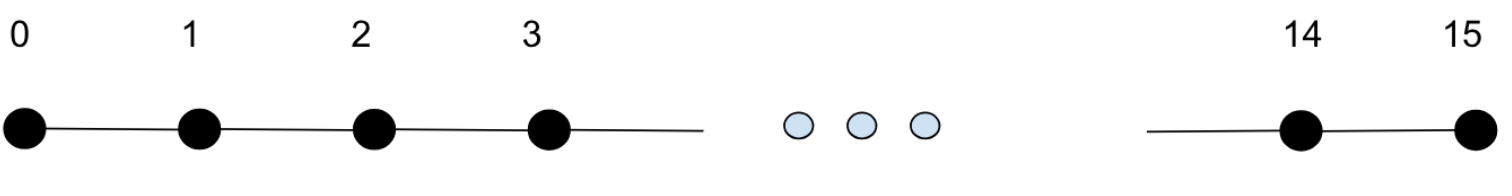

In [29]:
#Imports
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences

In [30]:
size = 4 # Number of qubits to represent the vertices (log2 of 16 nodes)
num_nodes = 2**size # Total number of nodes (16 nodes)

Coin Operator

When we talk about  the coin operator we refer to a quantum analog of flipping a coin, which determines the walker's movement probabilities. The purpose of the coin operator is to transform the walker's state by assigning amplitudes to move left or right from each node. For example, if the walker is at node 0, the coin operator will set the probability to move to node 1. If the walker is at node 15, it will set the probability to move to node 14. And For nodes in between, the probabilities are distributed evenly to move either left or right.

For the proc Iss,i setup the probability based on the above discussed idea. i, then, use a diffuser oracle to amplify the probabilities of adjacent nodes.s.

In [32]:
# Function to prepare a qubit in the |-> state
@qfunc
def prepare_minus(x: QBit):
    """
    Prepares a qubit in the |-> state.
    
    Args:
        x (QBit): The qubit to prepare.
    """
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    """
    Implements a diffuser oracle for Grover's algorithm.
    
    Args:
        aux (Output[QNum]): Auxiliary qubit.
        x (QNum): QNum representing the node to check.
    """
    aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):
    """
    Implements the zero diffuser for the quantum walk.
    
    Args:
        x (QNum): QNum representing the current node.
    """
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    """
    Defines the coin operation for the quantum walk.
    
    Args:
        i (int): Current node index.
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    prob = [0]*num_nodes  # Initialize probability vector for 16 nodes
    if i == 0:
        prob[i + 1] = 1.0  # If at the first node, move to the right node (node 1)
    elif i == num_nodes - 1:
        prob[i - 1] = 1.0  # If at the last node, move to the left node (node 14)
    else:
        prob[i - 1] = 0.5  # Probability of moving to the left node
        prob[i + 1] = 0.5  # Probability of moving to the right node
    print(f'Node={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    """
    Applies the coin operator to all vertices.
    
    Args:
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    for i in range(num_nodes):
        C_iteration(i,vertices,adjacent_vertices)

Coin Operator Circuit

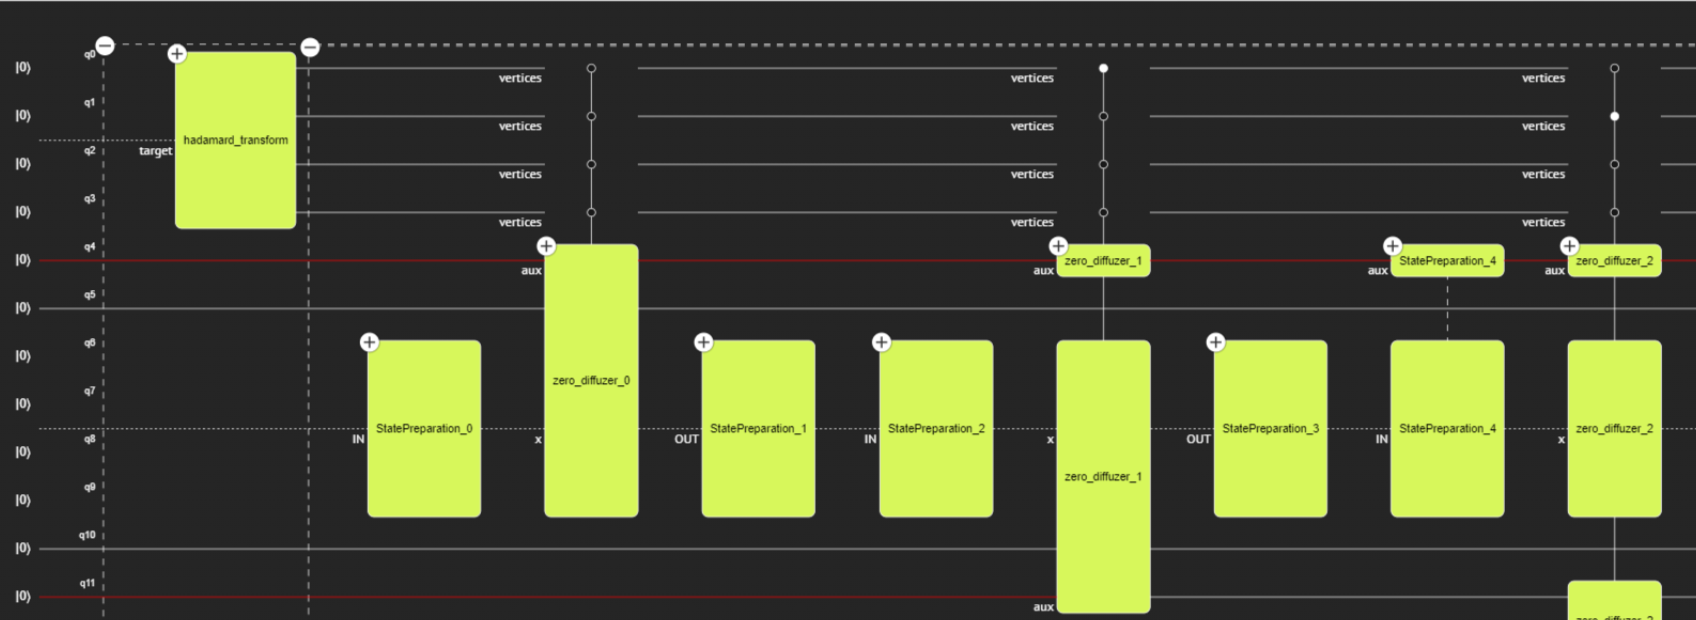

Shift Operator

For starters after determining the movement probabilities, whats known as the shift operator is applied. This operator then executes the movement by swapping the walker's state between nodes according to the amplitudes set by the coin operato r.And If the quantum state of the walker indicates a move from node 7 to nodes 6 and 8, the shift operator adjusts the state to reflect these new positions. Also something to add is that quantum interference can occur during this step, where the probability amplitudes of different paths combine, enhancing or diminishing the likelihood of certain outcomes.

In [34]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    """
    Oracle that checks if two vertices are adjacent.
    
    Args:
        res (Output[QBit]): Result bit to store the adjacency check.
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    """
    Swaps the values of two QArrays bit by bit.
    
    Args:
        x (QArray[QBit]): First QArray of qubits.
        y (QArray[QBit]): Second QArray of qubits.
    """
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i])) 

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    """
    Applies the shift operator to swap vertices with their adjacent vertices.
    
    Args:
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

Shift Operator Circuit

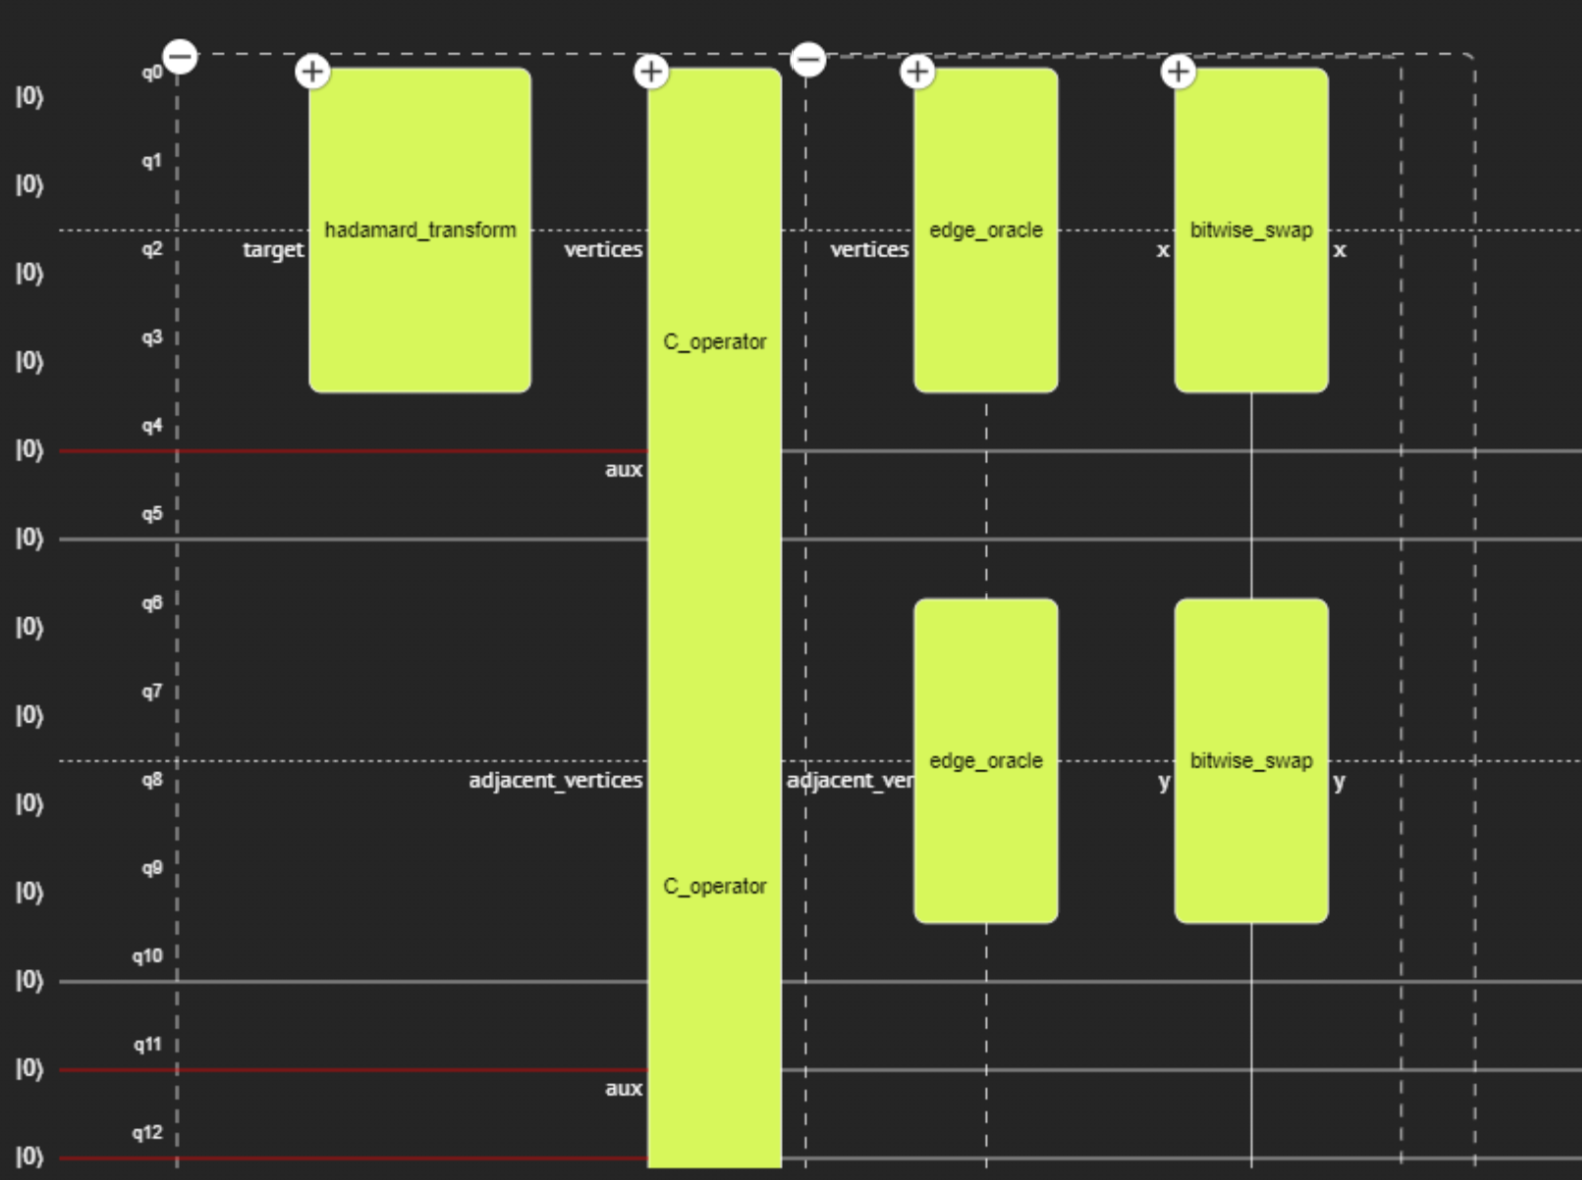

So now its time to put all these together to form a quantum walk.

This process begins by initializing the walker in a superposition of all possible positions along the line. This is commonly achieved by using quantum gates, such as the Hadamard gate, which can create an equal probability amplitude for the walker to be found at any of the 16 nodes. So when its put in mathematical terms, the walker's initial state can be represented as a superposition of basis states ∣0⟩, ∣1⟩,..., ∣15⟩, where each basis state corresponds to one of the nodes.

In [36]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    """
    Main function to perform the quantum random walk.
    
    Args:
        vertices (Output[QNum]): Output QNum to represent vertices.
        adjacent_vertices (Output[QNum]): Output QNum to represent adjacent vertices.
    """
    allocate(size, vertices)  # Allocate qubits for vertices
    hadamard_transform(vertices)  # Apply Hadamard transform to initialize superposition
    allocate(size, adjacent_vertices)  # Allocate qubits for adjacent vertices
    
    C_operator(vertices, adjacent_vertices)  # Apply coin operator
    S_operator(vertices, adjacent_vertices)  # Apply shift operator
# Create and synthesize the quantum model
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node

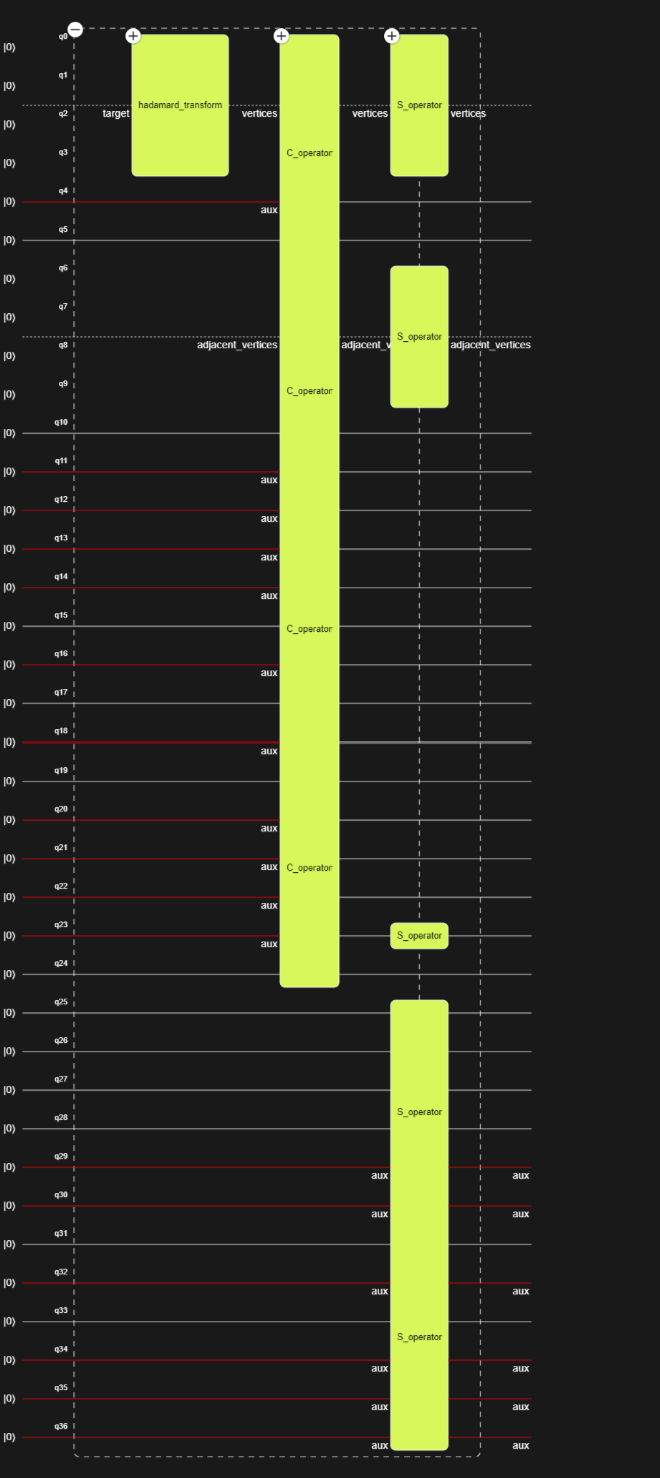